In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from biom import load_table
import matplotlib.pyplot as plt
import seaborn as sns
#from gneiss.util import match
from scipy.spatial import KDTree
from scipy.stats import rankdata
from skbio.stats.composition import clr, clr_inv, centralize
from sklearn.neighbors import NearestNeighbors, KDTree
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from src.evaluate import _edge_roc_curve


from matplotlib import rc
import matplotlib
%matplotlib inline

/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jmorto

In [2]:
!ls ../results/soil_output/rerun

prop_matrix_soil_PHI.csv      prop_matrix_soil_pearson.csv
prop_matrix_soil_RHO.csv      prop_matrix_soil_spearman.csv


In [3]:
tools = ['mmvec', 'spearman', 'pearson', 'phi', 'rho']
fnames = [
    'mmvec_ranks.csv',
    'rerun/prop_matrix_soil_pearson.csv',
    'rerun/prop_matrix_soil_spearman.csv',
    'rerun/prop_matrix_soil_PHI.csv',
    'rerun/prop_matrix_soil_RHO.csv'
]

In [4]:
select_microbes = ['rplo 1 (Cyanobacteria)', 'rplo 2 (Firmicutes)', 
                   'rplo 60 (Firmicutes)', 'rplo 7 (Actinobacteria)']
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetylornithine', 'succinate', 
                           'adenosine', 'guanine', 'adenine']

In [5]:
ranks = pd.read_csv(os.path.join('../results/soil_output', fnames[0]), index_col=0)

In [6]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [7]:
edges = pd.DataFrame(list(zip(['rplo 1 (Cyanobacteria)'] * len(microcoleus_metabolites), 
                     microcoleus_metabolites)), columns=['microbe', 'metabolite'])
edges['direction'] = 'R'

microbes = list(ranks.columns)
metabolites = list(ranks.columns)
other_metabolites = list(set(metabolites) - set(microcoleus_metabolites))

other_edges = pd.DataFrame(other_metabolites, columns=['metabolite'])
other_edges['microbe'] = 'rplo 1 (Cyanobacteria)'
other_edges['direction'] = 0

edges = pd.concat((edges, other_edges), axis=0)
edges = edges[['microbe', 'metabolite', 'direction']]

/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [8]:
def read_df(fname):
    if '.txt' in fname:
        return pd.read_table(os.path.join('../results/soil_output', fname), 
                                          index_col=0)
    else:
        return pd.read_csv(os.path.join('../results/soil_output', fname), 
                                        index_col=0)
    
rankz = list(map(read_df, fnames))

In [9]:
def roc_f(ranks, tool):
    r = ranks.T[['rplo 1 (Cyanobacteria)']].loc[metabolites].T
    if tool == 'phi':
        r = 1 / r
        
    res = _edge_roc_curve(r, edges, k_max=40)
    return res
rocs = list(map(lambda x: roc_f(x[0], x[1]), zip(rankz, tools)))

In [10]:
for res in rocs:
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/jmorton/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


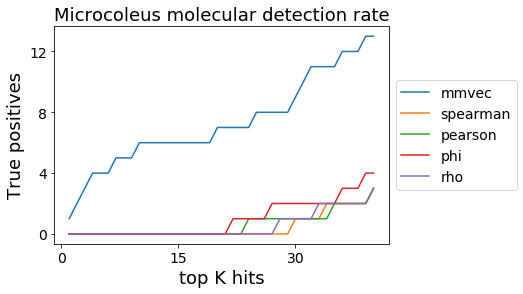

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
#plt.subplots_adjust(wspace=0.4, hspace=0.5)

for tool, roc in zip(tools, rocs):
    ax.plot(roc[0]['TP'], label=tool)            
    ax.set_ylabel('True positives', fontsize=18)
    ax.set_xlabel('top K hits', fontsize=18)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))      

ax.set_title('Microcoleus molecular detection rate', fontsize=18)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
fig.savefig('Figure3b.svg')

In [14]:
load_table('../data/soils/microbes.biom')

466 x 20 <class 'biom.table.Table'> with 4770 nonzero entries (51% dense)